# Mid-Distance Performance Analysis

This is an analysis of the relationships between middle-distance events. I'm mostly interested in the 800, but the general idea is to be able to predict a certain race's outcome based on your performance in other events. Particularly, being able to predict your 800m time based off of your 400m and/or 1500m/mile time.

In [5]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

## TFRRS Data

The links in the following dictionary have been obtained by going to the TFRRS database archives, finding the men's 800m for the desired season/year, inspecting the table, and finding the src argument of the turbo-frame tag with id = 'list_data'. There are some patterns in the URLs, but the only consistent ones are the ones I've already automated. There are still random differences at times between divisions and between indoor and outdoor seasons.

[Example](https://tf.tfrrs.org/lists/3901/2022_2023_NCAA_Div_I_Indoor_Qualifying_FINAL):

> `<turbo-frame id="list_data" src="https://tf.tfrrs.org/list_data/3901?other_lists=`
> `https%3A%2F%2Fm.tfrrs.org%2Flists%2F3901%2F2022_2023_NCAA_Div_I_Indoor_Qualifying`
> `_FINAL&amp;limit=100&amp;event_type=53&amp;year=&amp;gender="> ... </turbo-frame>`

In [1]:
di_dict = {
    'indoor_2022': 'https://tf.tfrrs.org/list_data/3492?other_lists=https%3A%2F%2Ftf.tfrrs.org%2Flists%2F3492%2F2021_2022_NCAA_Div_I_Indoor_Qualifying_FINAL&limit=500&event_type=54&year=&gender=m',
    'outdoor_2022': 'https://tf.tfrrs.org/list_data/3711?other_lists=https%3A%2F%2Fxc.tfrrs.org%2Flists%2F3711%2F2022_NCAA_Division_I_Outdoor_Qualifying_FINAL&limit=500&event_type=12&year=&gender=m',
    'indoor_2023': 'https://tf.tfrrs.org/list_data/3901?other_lists=https%3A%2F%2Fm.tfrrs.org%2Flists%2F3901%2F2022_2023_NCAA_Div_I_Indoor_Qualifying_FINAL&limit=500&event_type=54&year=&gender=m',
    'outdoor_2023': 'https://tf.tfrrs.org/list_data/4044?other_lists=https%3A%2F%2Ftf.tfrrs.org%2Flists%2F4044%2F2023_NCAA_Division_I_All_Schools_Rankings&limit=500&event_type=12&year=&gender=m',
    'indoor_2024': 'https://tf.tfrrs.org/list_data/4364?other_lists=https%3A%2F%2Fmobile.tfrrs.org%2Flists%2F4364%2F2023_2024_NCAA_Div_I_Indoor_Qualifying_FINAL&limit=500&event_type=54&year=&gender=m',
}

def create_dx_dict(dict: dict, division: str) -> dict:
    '''Updates the values of the DI dictionary to correspond with DII and DIII URLs. There are still some inconsistencies, so some values will have to be manually fixed after the function.
    
    Parameters:
        dict (dict): the NCAA DI Dictionary of URLs
        division (str): 'II' or 'III' to match DII or DIII
        
    Returns:
        dx_dict (dict): a dict with updated values to match the corresponding NCAA division'''
    
    dx_dict = {}
    for season in dict:
        new_url = dict[season].replace('_I_', f'_{division}_')

        table_id = dict[season].split('?')[0][-4:]
        new_table_id = str(int(table_id) + len(division))
        new_url = new_url.replace(table_id, new_table_id)
        
        dx_dict[season] = new_url

    return dx_dict


dii_dict = create_dx_dict(di_dict, 'II')     
dii_dict['outdoor_2022'] = 'https://tf.tfrrs.org/list_data/3595?other_lists=https%3A%2F%2Fupload.tfrrs.org%2Flists%2F3595%2F2022_NCAA_Division_II_Outdoor_Qualifying_FINAL&limit=500&event_type=12&year=&gender=m'

diii_dict = create_dx_dict(di_dict, 'III')
diii_dict['indoor_2024'] = 'https://tf.tfrrs.org/list_data/4366?other_lists=https%3A%2F%2Fupload.tfrrs.org%2Flists%2F4366%2F2023_2024_NCAA_Div_III_Indoor_Qualifying_FINAL&limit=500&event_type=54&year=&gender=m'

naia_dict = {
    'indoor_2022': 'https://tf.tfrrs.org/list_data/3495?other_lists=https%3A%2F%2Fwww.tfrrs.org%2Flists%2F3495%2F2021_2022_NAIA_Indoor_Qualifying_FINAL&limit=500&event_type=54&year=&gender=m',
    'outdoor_2022': 'https://tf.tfrrs.org/list_data/3596?other_lists=https%3A%2F%2Fwww.tfrrs.org%2Flists%2F3596%2F2022_NAIA_Outdoor_Qualifying_List_FINAL&limit=500&event_type=12&year=&gender=m',
    'indoor_2023': 'https://tf.tfrrs.org/list_data/3904?other_lists=https%3A%2F%2Fwww.tfrrs.org%2Flists%2F3904%2F2022_2023_NAIA_Indoor_Qualifying_List_FINAL&limit=500&event_type=54&year=&gender=m',
    'outdoor_2023': 'https://tf.tfrrs.org/list_data/4046?other_lists=https%3A%2F%2Fmobile.tfrrs.org%2Flists%2F4046%2F2023_NAIA_Outdoor_Qualifying_FINAL&limit=500&event_type=12&year=&gender=m',
    'indoor_2024': 'https://tf.tfrrs.org/list_data/4368?other_lists=https%3A%2F%2Fm.tfrrs.org%2Flists%2F4368%2F2023_2024_NAIA_Indoor_Qualifying_List_FINAL&limit=500&event_type=54&year=&gender=m',
}

njcaa_dict = {
    'indoor_2022': 'https://tf.tfrrs.org/list_data/3496?other_lists=https%3A%2F%2Ftf.tfrrs.org%2Flists%2F3496%2F2021_2022_NJCAA_Indoor_Qualifying_List&limit=500&event_type=54&year=&gender=m',
    'outdoor_2022': 'https://tf.tfrrs.org/list_data/3717?other_lists=https%3A%2F%2Ftf.tfrrs.org%2Flists%2F3717%2FNJCAA_All_Schools_Outdoor_Performance_List&limit=500&event_type=12&year=&gender=m',
    'indoor_2023': 'https://tf.tfrrs.org/list_data/3905?other_lists=https%3A%2F%2Fmobile.tfrrs.org%2Flists%2F3905%2F2022_2023_NJCAA_Indoor_Qualifying_List&limit=500&event_type=54&year=&gender=m',
    'outdoor_2023': 'https://tf.tfrrs.org/list_data/4201?other_lists=https%3A%2F%2Ftf.tfrrs.org%2Flists%2F4201%2FNJCAA_All_Schools_Outdoor_Performance_List&limit=500&event_type=12&year=&gender=m',
    'indoor_2024': 'https://tf.tfrrs.org/list_data/4367?other_lists=https%3A%2F%2Fm.tfrrs.org%2Flists%2F4367%2F2023_2024_NJCAA_Indoor_Qualifying_List&limit=500&event_type=54&year=&gender=m',
}

In [2]:
from scrape_tfrrs import TFRRSScraper
from glob import glob

tfrrs = TFRRSScraper()

if not glob('data/tfrrs*.csv'):
    di_tfrrs = tfrrs.download_seasons(di_dict, division='di')
    dii_tfrrs = tfrrs.download_seasons(dii_dict, division='dii')
    diii_tfrrs = tfrrs.download_seasons(diii_dict, division='diii')
    naia_tfrrs = tfrrs.download_seasons(naia_dict, division='naia')
    njcaa_tfrrs = tfrrs.download_seasons(njcaa_dict, division='njcaa')
else:
    print('[INFO] TFRRS data found in data directory')
    df_tfrrs = tfrrs.merge_tfrrs_data()

[INFO] TFRRS data found in working directory


In [6]:
df_milesplit = pd.read_csv('milesplit_indoor_2023-outdoor_2023.csv')


<Axes: xlabel='time_400', ylabel='time_800'>

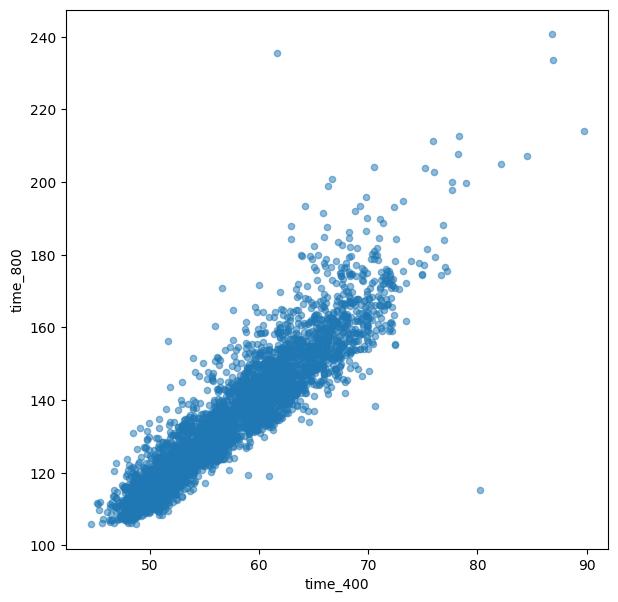

In [11]:
df_all = pd.concat([df_tfrrs, df_milesplit]).drop_duplicates()

df_all.plot(
    kind='scatter',
    x='time_400',
    y='time_800',
    figsize=(7,7),
    alpha = 0.5
)

In [36]:
lm = smf.ols(formula='time_800~time_400', data = df_all).fit()
lm.summary()

TypeError: PredictionResults.__init__() missing 1 required positional argument: 'predicted_mean'

<Axes: xlabel='time_400', ylabel='time_800'>

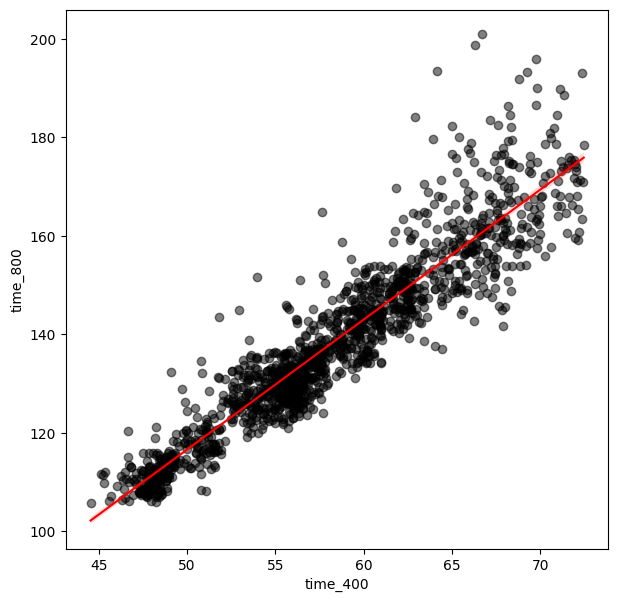

In [59]:
# plt.figure(figsize = (7,7))
# plt.scatter(x=df_all['time_400'], y=df_all['time_800'])

# b, a = np.polyfit(df_all['time_400'], df_all['time_800'], deg=1)
# xseq = np.linspace(df_all['time_400'].min(), df_all['time_400'].max(), num=100)

# plt.plot(xseq, a + b * xseq, c = 'black', lw = 2)

plt.figure(figsize = (7,7))
sns.regplot(x='time_400', y='time_800', data=df_all,
            scatter_kws={'color': 'black', 
                         'alpha': 0.5},
            line_kws={'color': 'red',
                      'lw': 1.5})